## This notebook contains 
1. Image pre-processing work done to remove white spaces. 
2. Figuring out which page in multipage tiff image to use.
3. converting tiff to jpg and storing image to futher processing.

In [1]:
import numpy as np 
import pandas as pd 
import slidingwindow as sw 
import skimage 
from skimage import io 
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import os 

In [2]:
BASE_FOLDER = "/project/data/"   # if on gcloud 

!ls {BASE_FOLDER}

train = pd.read_csv(os.path.join(BASE_FOLDER, 'train.csv'))
# test = pd.read_csv(os.path.join(BASE_FOLDER, 'test.csv'))

image_dir = os.path.join(BASE_FOLDER, 'train_images/')
# mask_dir = os.path.join(BASE_FOLDER, 'train_label_masks')

sample_submission.csv  test.csv   train_images
small_train.csv        train.csv  train_label_masks


### Part 1

### Extracting Original tiff multipage image , there are 3 pages with different resolution . 16x, 8x, 4x. 


In [3]:
image_id = '3bbe8e2a01ca4d4e8cda9a6bb5491ad7'

image_file_path = os.path.join(image_dir,image_id + ".tiff")

hires_image = skimage.io.MultiImage(image_file_path)[0]
hires_image = np.array(hires_image)

midres_image = skimage.io.MultiImage(image_file_path)[1]
midres_image = np.array(midres_image)

lowres_image = skimage.io.MultiImage(image_file_path)[2]
lowres_image = np.array(lowres_image)

print("hi-resolution image shape {} ,mid-resolution image shape {}, low-resolution image shape {}".format(hires_image.shape, midres_image.shape, lowres_image.shape))

hi-resolution image shape (31488, 35840, 3) ,mid-resolution image shape (7872, 8960, 3), low-resolution image shape (1968, 2240, 3)


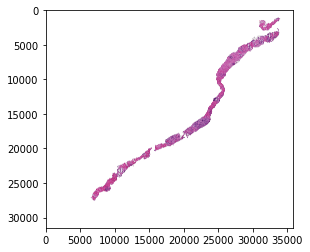

In [4]:
imgplot = plt.imshow(hires_image)

In [5]:
def compute_statistics(image):
    """
    Args:
        image                  numpy.array   multi-dimensional array of the form WxHxC
    
    Returns:
        ratio_white_pixels     float         ratio of white pixels over total pixels in the image 
    """
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height
    
    num_white_pixels = 0
    
    summed_matrix = np.sum(image, axis=-1)
    # Note: A 3-channel white pixel has RGB (255, 255, 255)
    num_white_pixels = np.count_nonzero(summed_matrix > 620)
    ratio_white_pixels = num_white_pixels / num_pixels
    
    green_concentration = np.mean(image[1])
    blue_concentration = np.mean(image[2])
    
    return ratio_white_pixels, green_concentration, blue_concentration

def select_k_best_regions(regions, k=20):
    """
    Args:
        regions               list           list of 2-component tuples first component the region, 
                                             second component the ratio of white pixels
                                             
        k                     int            number of regions to select
    """
    regions = [x for x in regions if x[3] > 180 and x[4] > 180]
    k_best_regions = sorted(regions, key=lambda tup: tup[2])[:k]
    return k_best_regions

def generate_patches(image, window_size=200, stride=128, k=20):
    
#     image = skimage.io.MultiImage(slide_path)[-2]
#     image = np.array(image)
    
    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []
    i = 0
    
    while window_size + stride*i <= max_height:
        j = 0
        
        while window_size + stride*j <= max_width:            
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride
            
            patch = image[
                x_top_left_pixel : x_top_left_pixel + window_size,
                y_top_left_pixel : y_top_left_pixel + window_size,
                :
            ]
            
            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)
            
            j += 1
        
        i += 1
    
    k_best_region_coordinates = select_k_best_regions(regions_container, k=k)
    k_best_regions = get_k_best_regions(k_best_region_coordinates, image, window_size)
    
    return image, k_best_region_coordinates, k_best_regions

def display_images(regions, title):
    fig, ax = plt.subplots(5, 4, figsize=(15, 15))
    
    for i, region in regions.items():
        ax[i//4, i%4].imshow(region)
    
    fig.suptitle(title)
    
    
def get_k_best_regions(coordinates, image, window_size=512):
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x : x+window_size, y : y+window_size, :]
    
    return regions


def glue_to_one_picture(image_patches, window_size=200, k=16):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in image_patches.items():
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [ ]:
WINDOW_SIZE = 256
STRIDE = 64
K = 16
        
hires_image, best_coordinates, best_regions_hires = generate_patches(hires_image, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
hires_glued_image = glue_to_one_picture(best_regions_hires, window_size=WINDOW_SIZE, k=K)

midres_image, best_coordinates, best_regions_midres = generate_patches(midres_image, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
midres_glued_image = glue_to_one_picture(best_regions_midres, window_size=WINDOW_SIZE, k=K)

lowres_image, best_coordinates, best_regions_lowres = generate_patches(lowres_image, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
lowres_glued_image = glue_to_one_picture(best_regions_lowres, window_size=WINDOW_SIZE, k=K)



In [ ]:
imgplot = plt.imshow(midres_glued_image)
midres_glued_image.shape

In [ ]:
my_dpi = 400
fig = plt.figure(figsize=(3, 3), dpi=my_dpi)

# ============ AX1 ============ 
# High Resolution Image
ax1 = fig.add_subplot(1, 3, 1)
# ax1.set_title("Hi-Resolution Image")
ax1.set_title("Hi-Res")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(hires_glued_image)


# ============ AX2 ============ 
# Mid Resolution Image
ax2 = fig.add_subplot(1, 3, 2)
# ax1.set_title("Mid-Resolution Image")
ax2.set_title("Mid-Res")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(midres_glued_image)


# ============ AX3 ============ 
# Low Resolution Image
ax3 = fig.add_subplot(1, 3, 3)
# ax1.set_title("Low-Resolution Image")
ax3.set_title("Low-Res")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.imshow(lowres_glued_image)


In [ ]:
windows = sw.generate(midres_glued_image, sw.DimOrder.HeightWidthChannel, 512, 0.5)
print("Number of sliding windows generated {}".format(len(windows)))
list_subset_images = []

for window in windows:
    subset = midres_glued_image[ window.indices() ]
    list_subset_images.append(subset)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
# image modules
from PIL import Image
import matplotlib.image as mpimg 
# import cv2
# PyTorch
import torch
from torch.utils import data
from torchvision import transforms
# other module
import os

my_dpi = 200
fig = plt.figure(figsize=(6, 6), dpi=my_dpi)

# ============ AX1 ============ 
# PIL Image
ax1 = fig.add_subplot(3, 3, 1)
ax1.set_title("Image 1")
ax1.set_xticks([])
ax1.set_yticks([])
# pil_img = Image.open(os.path.join('my_data', 'img1.jpg'))
ax1.imshow(list_subset_images[0])

# ============ AX2 ============ 
# mpimg image
ax2 = fig.add_subplot(3, 3, 2)
ax2.set_title("Image 2")
ax2.set_xticks([])
ax2.set_yticks([])
# mpimg_img = mpimg.imread(os.path.join('my_data', 'img2.jpg')) 
ax2.imshow(list_subset_images[1])

# ============ AX3 ============ 
# CV2 image (default)
ax3 = fig.add_subplot(3, 3, 3)
ax3.set_title("image 3")
ax3.set_xticks([])
ax3.set_yticks([])
# opencv_img = cv2.imread(os.path.join('my_data', 'img3.jpg'))
ax3.imshow(list_subset_images[2])

# ============ AX4 ============ 
# CV2 image (transform)
ax4 = fig.add_subplot(3, 3, 4)
ax4.set_title("image 4")
ax4.set_xticks([])
ax4.set_yticks([])
# cv2_img = cv2.imread(os.path.join('my_data', 'img3.jpg'))
# mod_cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB) 
ax4.imshow(list_subset_images[3])

# ============ AX5 ============ 
# CV2 image (transform)
ax5 = fig.add_subplot(3, 3, 5)
ax5.set_title("image 5")
ax5.set_xticks([])
ax5.set_yticks([])
ax5.imshow(list_subset_images[4])

# ============ AX6 ============ 
# PIL image. With PyTorch, tensorise and de-tensorise
ax6 = fig.add_subplot(3, 3, 6)
ax6.set_title("image 6")
ax6.set_xticks([])
ax6.set_yticks([])
ax6.imshow(list_subset_images[5])



# ============ AX7 ============ 
# PIL image. With PyTorch, tensorise and de-tensorise
ax7 = fig.add_subplot(3, 3, 7)
ax7.set_title("image 7")
ax7.set_xticks([])
ax7.set_yticks([])
ax7.imshow(list_subset_images[6])


# ============ AX8 ============ 
# PIL image. With PyTorch, tensorise and de-tensorise
ax8 = fig.add_subplot(3, 3, 8)
ax8.set_title("image 8")
ax8.set_xticks([])
ax8.set_yticks([])
ax8.imshow(list_subset_images[7])


# ============ AX9 ============ 
# PIL image. With PyTorch, tensorise and de-tensorise
ax9 = fig.add_subplot(3, 3, 9)
ax9.set_title("image 9")
ax9.set_xticks([])
ax9.set_yticks([])
ax9.imshow(list_subset_images[8])



## Part 2 
We are selecting mid-resolution images for the image augmentation

In [ ]:
small_train = pd.read_csv(os.path.join(BASE_FOLDER, 'small_train.csv'))

small_train.head()

midres_image, best_coordinates, best_regions_midres = generate_patches(midres_image, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
midres_glued_image = glue_to_one_picture(best_regions_midres, window_size=WINDOW_SIZE, k=K)


image_id = '3bbe8e2a01ca4d4e8cda9a6bb5491ad7'

image_file_path = os.path.join(image_dir,image_id + ".tiff")

hires_image = skimage.io.MultiImage(image_file_path)[0]
hires_image = np.array(hires_image)

midres_image = skimage.io.MultiImage(image_file_path)[1]
midres_image = np.array(midres_image)

In [ ]:
from skimage import img_as_ubyte
skimage.io.imsave("midres.jpeg",img_as_ubyte(midres_glued_image),quality=100)

In [ ]:
img =skimage.io.imread("midres.jpeg")

In [ ]:
plt.imshow(img)

### Part 3
Convert .tiff files into jpg, assumption : we take channel 2 (resolution of 8x) 
### generate list of files and convert 1000 images in batches to avoid duplication

In [4]:
# # files = get_image_files(image_dir)
# part2 = files[1000:2000]
# part3 = files[2000:3000]
# part4 = files[3000:4000]
# part5 = files[4000:5000]
# part6 = files[5000:6000]
# part7 = files[6000:7000]
# part8 = files[7000:8000]
# part9 = files[8000:9000]
# part10 = files[9000:10000]
# part11 = files[10000:]

In [2]:
# for file_path  in part11:
#     file_path = str(file_path)
#     temp_file_path = file_path
#     image_id = temp_file_path.split("/")[-1]   

#     label_class = label_func(file_path)
    
#     my_path = '/home/abharani/data/train_images/'
    
#     print(image_id)
#     command = 'convert ' + str(file_path) + "[1]" + ' ' + my_path + image_id.replace('.tiff',"_" + str(label_class)+ '.jpg')
#     print(command)
    
#     try:
#         os.system(command)    
#         pass
#     except:
#         print("Issue with image_id {}".format(image_id))

#### Compare Image after conversion

In [3]:
def comparision(image_id):
    original_image = skimage.io.MultiImage('/project/data/train_images/' + image_id + '.tiff')[1]
    label_class = train.loc[train['image_id']==image_id]['isup_grade'].values[0]
    
    converted_image = skimage.io.MultiImage('/home/abharani/data/train_images/'+ str(label_class) + '/' + image_id + '.jpg')[0]
    
    print(original_image.shape)
    print(converted_image.shape)    
    
# comparision('1d735506b1d8339520792d6e8ccb2194')  

### Notebook Ends 

In [ ]:
img =skimage.io.imread('/project/yi_data/panda-16x128x128-tiles-data/train/cd0ea1fcb034376845c7af09d2154603_9.png')
plt.imshow(img)

In [ ]:
from utils import *
from fastai2.vision.widgets import *
path = Path(image_dir)
print(path)
fns = get_image_files(path)
print(fns)

# Data loader part starts 

In [ ]:
# from PIL import Image
# from PIL import ImageSequence
# from PIL import TiffImagePlugin

# INFILE  = 'multipage_tif_example.tif'
# OUTFILE = 'multipage_tif_resized.tif'

# print ('Resizing TIF pages')
# pages = []
# imagehandler = Image.open(INFILE)
# for page in ImageSequence.Iterator(imagehandler):
#     new_size = (page.size[0]/2, page.size[1]/2)
#     page = page.resize(new_size, Image.ANTIALIAS)
#     pages.append(page)

# print ('Writing multipage TIF')
# with TiffImagePlugin.AppendingTiffWriter(OUTFILE) as tf:
#     for page in pages:
#         page.save(tf)
#         tf.newFrame()